Link to the video presentation: https://www.youtube.com/watch?v=aYgFwE8OtmU

### Project Description

Context\
Gemstones, also known as gems, jewels, or precious and semi-precious stones, are pieces of mineral crystal or other organic materials that are cut and polished to be used in jewelry or other adornments. These beautiful and valuable items come in various shapes such as round, oval, square, rectangle, and heart, and their identification and classification play a crucial role in the gemstone industry.

Project Overview\
Our project focuses on recognizing gemstone categories based on image data to assist William, a well-known gemologist who is losing his sight. Mine owners worldwide seek his expertise in identifying gemstones, but the process is becoming difficult for him. To help, we developed a model that predicts gemstone categories from images.
Gemstones are colorful, uniquely shaped, and valuable, making them interesting for machine learning. We used a labeled dataset from Kaggle: https://www.kaggle.com/datasets/lsind18/gemstones-images, which is divided into train and test sets. Given the labeled data, we think to use supervised machine learning models to achieve accurate predictions.

Objective\
The objective of this project is to develop an image classification model that can classify images of gemstones into one of the 87 predefined classes. The system will be trained on a dataset of over 3,200 faceted gemstone images, with the data divided into training and testing sets in a ratio of approximately 90:10. The images are in .jpg format and vary in size.

### Imports

In [1]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
from colorthief import ColorThief
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.cluster import KMeans
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from prettytable import PrettyTable
from skimage.io import imshow
import io
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Input, Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from skimage.feature import hog
from skimage.color import rgb2gray
from skimage import color
from skimage import exposure
from numpy.random import seed, randint
from skimage.feature import hog

### Data exploration

In [2]:
dataset_folder = os.path.join(os.getcwd(),"Gemstones_dataset")

def count_images_per_category(root_dir):
    category_counts = {}
    for foldername in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, foldername)
        if os.path.isdir(folder_path):
            category_counts[foldername] = len(os.listdir(folder_path))
    return category_counts

train_folder = os.path.join(dataset_folder, 'train')
train_category_counts = count_images_per_category(train_folder)

test_folder = os.path.join(dataset_folder, 'test')
test_category_counts = count_images_per_category(test_folder)

combined_category_counts = {}
for category in sorted(set(list(train_category_counts.keys()) + list(test_category_counts.keys()))):
    combined_category_counts[category] = train_category_counts.get(category, 0) + test_category_counts.get(category, 0)

total_count = sum(combined_category_counts.values())

table = PrettyTable(['Category', 'Train Count', 'Test Count', 'Total Count'])
for category, count in combined_category_counts.items():
    train_count = train_category_counts.get(category, 0)
    test_count = test_category_counts.get(category, 0)
    table.add_row([category, train_count, test_count, count])

table.add_row(["Total", sum(train_category_counts.values()), sum(test_category_counts.values()), total_count])
print(table)

num_categories = len(combined_category_counts)
print(f"\nNumber of categories: {num_categories}")

+-------------------+-------------+------------+-------------+
|      Category     | Train Count | Test Count | Total Count |
+-------------------+-------------+------------+-------------+
|    Alexandrite    |      34     |     4      |      38     |
|     Almandine     |      31     |     4      |      35     |
|     Amazonite     |      32     |     4      |      36     |
|       Amber       |      31     |     4      |      35     |
|      Amethyst     |      35     |     4      |      39     |
|      Ametrine     |      35     |     4      |      39     |
|     Andalusite    |      32     |     4      |      36     |
|     Andradite     |      31     |     4      |      35     |
|     Aquamarine    |      36     |     5      |      41     |
|  Aventurine Green |      45     |     5      |      50     |
| Aventurine Yellow |      34     |     4      |      38     |
|     Benitoite     |      31     |     4      |      35     |
|    Beryl Golden   |      36     |     4      |      4

Visualizing random images from the dataset along with its corresponding gemstone category.

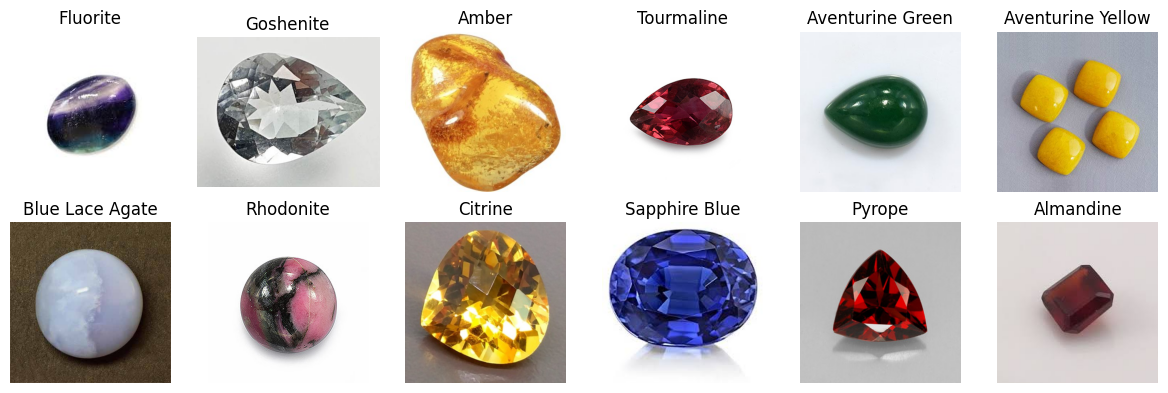

In [3]:
def show_random_images(root_dir, num_images=12):
    fig, axes = plt.subplots(2, 6, figsize=(12, 4))
    categories = os.listdir(root_dir)
    for i in range(num_images):
        category = random.choice(categories)
        category_folder = os.path.join(root_dir, category)
        image_file = random.choice(os.listdir(category_folder))
        image_path = os.path.join(category_folder, image_file)
        img = mpimg.imread(image_path)
        ax = axes[i // 6, i % 6]
        ax.imshow(img)
        ax.set_title(category)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

train_folder = os.path.join(dataset_folder, 'train')
show_random_images(train_folder)

Image: tsavorite_4.jpg, Size: 401x401
Image: tsavorite_30.jpg, Size: 301x301
Image: tsavorite_22.jpg, Size: 301x301
Image: tsavorite_31.jpg, Size: 301x301
Image: tsavorite_2.jpg, Size: 550x591
Image: tsavorite_16.jpg, Size: 290x290
Image: tsavorite_31.jpg, Size: 301x301
Image: tsavorite_1.jpg, Size: 440x440
Image: tsavorite_13.jpg, Size: 225x225
Image: tsavorite_10.jpg, Size: 340x340
Image: tsavorite_21.jpg, Size: 400x400
Image: tsavorite_15.jpg, Size: 290x290


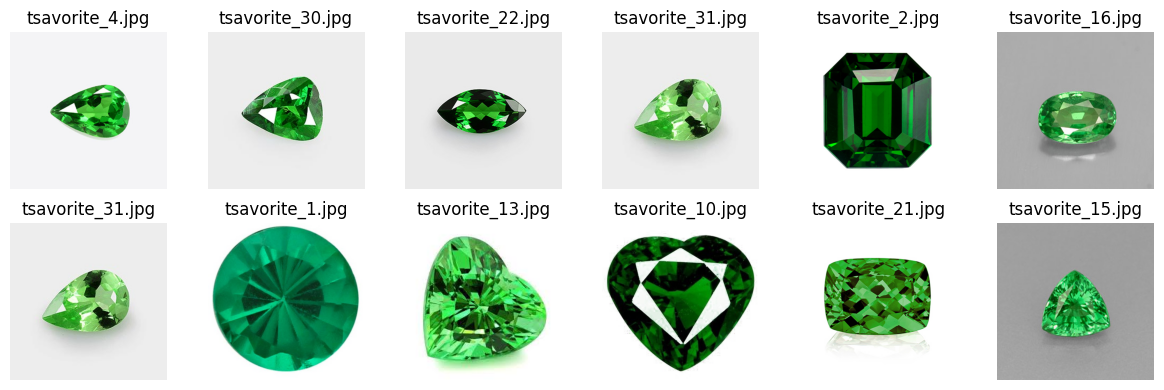

Image: coral_6.jpg, Size: 225x225
Image: coral_7.jpg, Size: 400x400
Image: coral_16.jpg, Size: 290x290
Image: coral_14.jpg, Size: 290x290
Image: coral_21.jpg, Size: 207x243
Image: coral_19.jpg, Size: 207x223
Image: coral_15.jpg, Size: 290x290
Image: coral_20.jpg, Size: 400x400
Image: coral_20.jpg, Size: 400x400
Image: coral_19.jpg, Size: 207x223
Image: coral_16.jpg, Size: 290x290
Image: coral_8.jpg, Size: 250x250


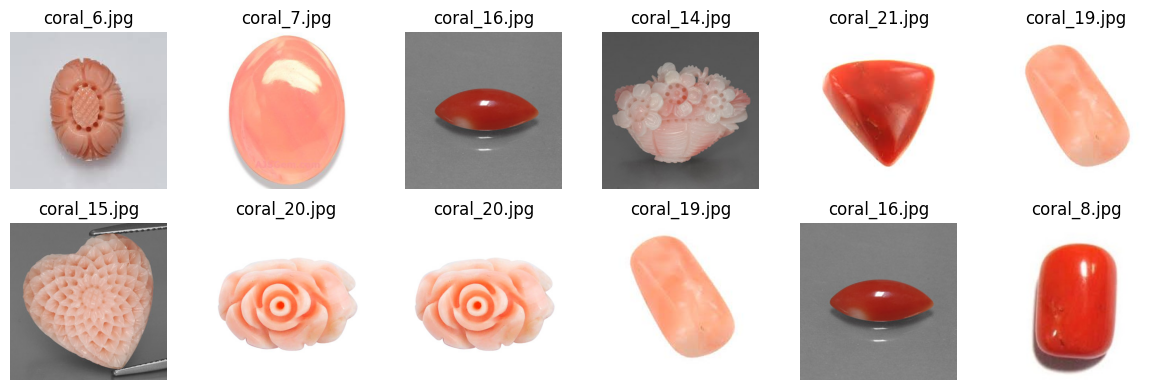

In [4]:
def show_random_images_from_directory(directory, num_images=12):
    fig, axes = plt.subplots(2, 6, figsize=(12, 4))
    image_files = os.listdir(directory)
    
    for i in range(num_images):
        image_file = random.choice(image_files)
        image_path = os.path.join(directory, image_file)
        img = mpimg.imread(image_path)
        ax = axes[i // 6, i % 6]
        ax.imshow(img)
        ax.set_title(os.path.basename(image_file))
        ax.axis('off')
        
        print(f"Image: {image_file}, Size: {img.shape[1]}x{img.shape[0]}")
    
    plt.tight_layout()
    plt.show()

directory = os.path.join(dataset_folder, 'train', 'Tsavorite')
show_random_images_from_directory(directory)
directory = os.path.join(dataset_folder, 'train', 'Coral')
show_random_images_from_directory(directory)

### Data preparation showcase
Before performing data preparation on the entire dataset, we apply the process to a sample image. This allows us to observe the results at each step of the preparation.

It's important to note from the data exploration phase that some images have backgrounds that are not white. 

Oryginal image


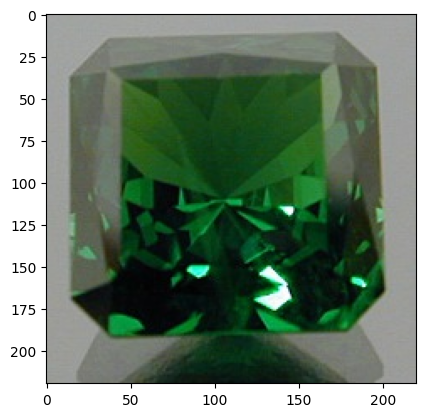

In [5]:
image = Image.open(os.path.join(os.getcwd(),os.path.join
                                ("Gemstones_dataset",os.path.join
                                 ("test",os.path.join
                                  (os.path.join
                                   ("Tsavorite","tsavorite_3.jpg"))))))
print('Oryginal image')
plt.imshow(image)
plt.show()

First, we convert the image to RGB format and then transform it into a NumPy array, where each pixel is represented by three values corresponding to the RGB channels. Next, we reshape the image data into a 2D array so that each row represents a pixel and each column represents a color channel.

In [6]:
image = image.convert("RGB")
data = np.array(image)
X_image = data.reshape(-1, 3)
X_image

array([[164, 164, 164],
       [164, 164, 164],
       [164, 164, 164],
       ...,
       [156, 156, 156],
       [156, 156, 156],
       [156, 156, 156]], dtype=uint8)

On the original image, we perform KMeans clustering with 4 clusters. Typically, background removal is done using 2 clusters, but this approach did not work well in our case, as many pixels were incorrectly classified as background. This issue is demonstrated in the code below. Therefore, we decided to use more than 2 clusters to improve accuracy. To determine which cluster corresponds to the background color, we check the cluster assignment of the first pixel.

c:\Users\IZO21\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Nie można odnaleźć określonego pliku
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\IZO21\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\IZO21\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\IZO21\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File 

Clustered image with only 2 clusters


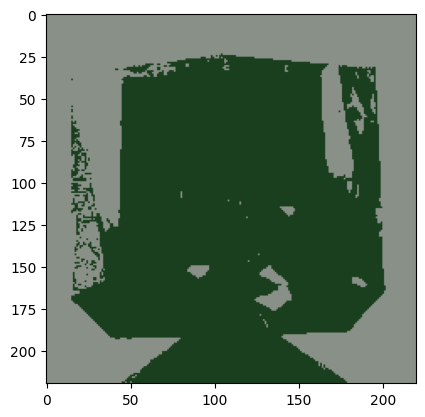

In [7]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_image)

first_pixel_cluster = kmeans.labels_[0]
mask = kmeans.labels_ == first_pixel_cluster

clustered_image_data = kmeans.cluster_centers_[kmeans.labels_].reshape(data.shape).astype(np.uint8)
clustered_image = Image.fromarray(clustered_image_data)

print('Clustered image with only 2 clusters')
plt.imshow(clustered_image)
plt.show()

Clustered image with 4 clusters


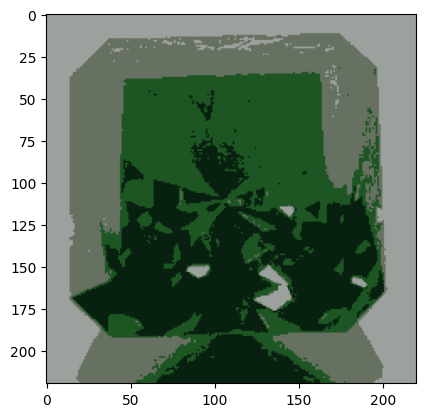

In [8]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_image)

first_pixel_cluster = kmeans.labels_[0]
mask = kmeans.labels_ == first_pixel_cluster

clustered_image_data = kmeans.cluster_centers_[kmeans.labels_].reshape(data.shape).astype(np.uint8)
clustered_image = Image.fromarray(clustered_image_data)

print('Clustered image with 4 clusters')
plt.imshow(clustered_image)
plt.show()

After identifying the cluster of the first pixel, we replace its color with white.

Clustered image with white background


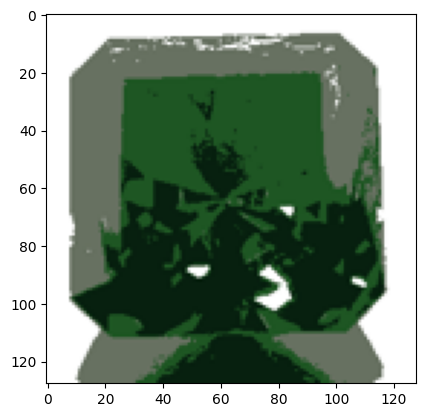

In [9]:
clustered_image_data[mask.reshape(clustered_image_data.shape[0], clustered_image_data.shape[1])] = [255, 255, 255]
clustered_image = Image.fromarray(clustered_image_data)
clustered_image = clustered_image.resize((128, 128))

print('Clustered image with white background')
plt.imshow(clustered_image)
plt.show()

We make a copy of the oryginal image and change the background to white.

Oryginal image with white background


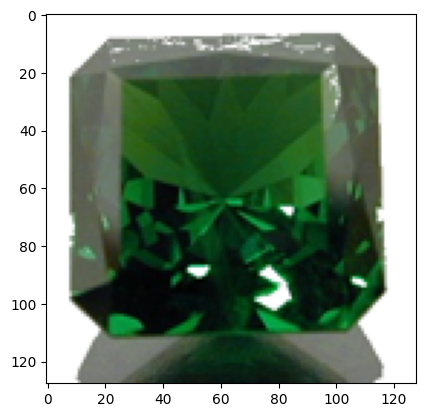

In [10]:
white_background_image_data = data.copy()
white_background_image_data[mask.reshape(data.shape[0], data.shape[1])] = [255, 255, 255]
white_background_image = Image.fromarray(white_background_image_data)
white_background_image = white_background_image.resize((128, 128))

print('Oryginal image with white background')
plt.imshow(white_background_image)
plt.show()

In [11]:
image_vector = np.array(white_background_image).flatten()
image_vector

array([255, 255, 255, ..., 255, 255, 255], dtype=uint8)

We use ColorThief on the clustered image with a white background. Since ColorThief works with file paths, we use io.BytesIO to simulate a file. This creates a file-like object from the bytes of the PIL.Image.

In [12]:
img_byte_arr = io.BytesIO()
clustered_image.save(img_byte_arr, format='PNG')
img_byte_arr = img_byte_arr.getvalue() 

color_thief = ColorThief(io.BytesIO(img_byte_arr))
dominant_color = color_thief.get_palette(color_count=2)
print(dominant_color)

[(45, 78, 49), (200, 204, 198), (140, 150, 140)]


Here, we can see the dominant colors extracted from the image.

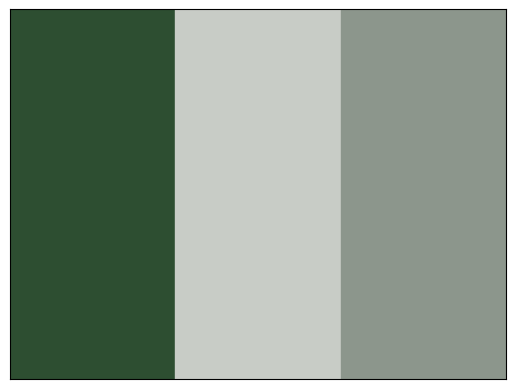

In [13]:
dominant_color_normalized = np.array(dominant_color) / 255.0
fig, ax = plt.subplots()

for i, color in enumerate(dominant_color_normalized):
    rect = plt.Rectangle((i, 0), 1, 1, color=color)
    ax.add_patch(rect)

ax.set_xlim(0, len(dominant_color_normalized))
ax.set_ylim(0, 1)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

We are converting the oryginal image with white bacground to grayscale using OpenCV.

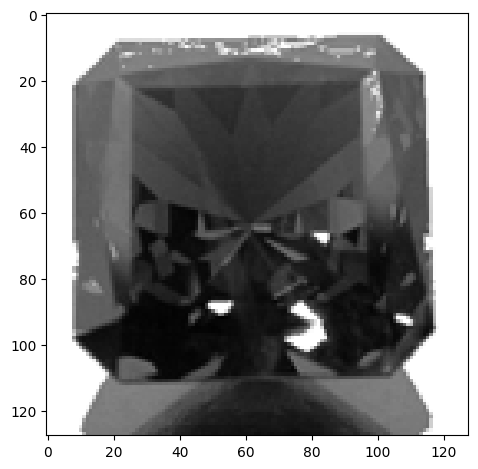

In [14]:
gray_image = cv2.cvtColor(np.array(white_background_image), cv2.COLOR_RGB2GRAY)
imshow(gray_image)

Using Canny algorithm we detect edges in a grayscale image, then calculating the edge density and the centroid of the edges. Edge density is determined by the mean value of the edges, and the centroid is computed using image moments.

In [15]:
edges = cv2.Canny(gray_image, 100, 200)

edge_density = np.mean(edges)

M = cv2.moments(edges)
if M["m00"] != 0:
    edge_centroid = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))
else:
    edge_centroid = (0, 0)
print("Edge Density:", edge_density)
print("Edge Centroid:", edge_centroid)

Edge Density: 27.62603759765625
Edge Centroid: (63, 66)


### Data preparation
In this loop, we perform the same data preparation as demonstrated earlier, but this time we apply it to the entire dataset. We then save the dominant colors, edge features, and flattened vectorized images to their respective data frames for later use in the process.

In [16]:
edge_features = []
vectorized_images = []
labels = []
dominant_colors = []

non_dominant_color = [255, 255, 255]

for subdir, dirs, files in os.walk(dataset_folder):
    for file in files:
        if file.endswith('.jpg'):
            file_path = os.path.join(subdir, file)
            
            image = Image.open(file_path).convert("RGB")
            data = np.array(image)

            X_image = data.reshape(-1, 3)
            kmeans = KMeans(n_clusters=4, random_state=42)
            kmeans.fit(X_image)

            first_pixel_cluster = kmeans.labels_[0]
            mask = kmeans.labels_ == first_pixel_cluster

            clustered_image_data = kmeans.cluster_centers_[kmeans.labels_].reshape(data.shape).astype(np.uint8)
            clustered_image_data[mask.reshape(clustered_image_data.shape[0], clustered_image_data.shape[1])] = [255, 255, 255]
            clustered_image = Image.fromarray(clustered_image_data)

            white_background_image_data = data.copy()
            white_background_image_data[mask.reshape(data.shape[0], data.shape[1])] = [255, 255, 255]
            white_background_image = Image.fromarray(white_background_image_data)

            clustered_image = clustered_image.resize((128, 128))
            white_background_image = white_background_image.resize((128, 128))

            image_vector = np.array(white_background_image).flatten()
            vectorized_images.append(image_vector)
            labels.append(subdir.split("\\")[-1])

            img_byte_arr = io.BytesIO()
            clustered_image.save(img_byte_arr, format='PNG')
            img_byte_arr = img_byte_arr.getvalue() 
        
            color_thief = ColorThief(io.BytesIO(img_byte_arr))
            dominant_color = color_thief.get_palette(color_count=2)
            dominant_colors.append(dominant_color)

            gray_image = cv2.cvtColor(np.array(white_background_image), cv2.COLOR_RGB2GRAY)
            edges = cv2.Canny(gray_image, 100, 200)
            
            edge_density = np.mean(edges > 0)
            M = cv2.moments(edges)
            edge_centroid = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"])) if M["m00"] != 0 else (0, 0)
            edge_features.append({'edge_density': edge_density, 'edge_centroid_x': edge_centroid[0], 'edge_centroid_y': edge_centroid[1]})

# Data frame with vecorized image with white background
df = pd.DataFrame(vectorized_images)
df['label'] = labels

# Data frame with the dominant colors taken from the clustered image with white background
dominant_df = pd.DataFrame(dominant_colors, columns=[f'dominant_color_{i+1}' for i in range(3)])
dominant_df['label'] = labels

# Data frame withe the edge features
edge_df = pd.DataFrame(edge_features)
edge_df['label'] = labels

# Combine DataFrames
dominant_edge_df = pd.concat([edge_df.drop(columns=['label']), dominant_df], axis=1)

The function is used to check the color columns and sum up the near-white ones. This allows us to determine how many of the dominant colors are close to white.

In [17]:
def is_white(rgb, threshold=240):
    return all(color >= threshold for color in rgb)

white_count = dominant_df[['dominant_color_1', 'dominant_color_2', 'dominant_color_3']].applymap(lambda x: is_white(x)).sum().sum()

print("Total number of white dominant colors:", white_count)

Total number of white dominant colors: 22


C:\Users\IZO21\AppData\Local\Temp\ipykernel_13688\2386511889.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  white_count = dominant_df[['dominant_color_1', 'dominant_color_2', 'dominant_color_3']].applymap(lambda x: is_white(x)).sum().sum()


Overview of dominant edge dataframe. Showing how data is presented and how values differ.
- We can see that edge density varies given specific gem type.
- Data type of dominant colors are tuples.

In [18]:
dominant_edge_df.head()

edge_density  edge_centroid_x  edge_centroid_y dominant_color_1  \
0      0.135559               62               63    (66, 98, 103)   
1      0.132629               62               65   (90, 115, 119)   
2      0.122559               64               61     (32, 87, 88)   
3      0.129639               55               63  (135, 167, 165)   
4      0.046692               66               47     (90, 41, 43)   

  dominant_color_2 dominant_color_3        label  
0  (220, 230, 231)  (156, 190, 190)  Alexandrite  
1  (210, 225, 225)  (163, 196, 195)  Alexandrite  
2  (118, 175, 188)  (199, 221, 227)  Alexandrite  
3     (54, 81, 71)  (228, 236, 236)  Alexandrite  
4  (210, 202, 203)  (148, 132, 140)    Almandine

Separating each color channel from tuples to separate columns.

In [19]:
dominant_edge_df_split = dominant_edge_df.copy()

def clean_and_split(rgb_string):
    rgb_string = str(rgb_string)
    rgb_string = rgb_string.strip('()')
    r, g, b = map(int, rgb_string.split(','))
    return r, g, b

for i in range(1, 4):
    dominant_edge_df_split[f'dominant_color_{i}_R'], dominant_edge_df_split[f'dominant_color_{i}_G'], dominant_edge_df_split[f'dominant_color_{i}_B'] = zip(*dominant_edge_df_split[f'dominant_color_{i}'].apply(clean_and_split))

dominant_edge_df_split.drop(columns=['dominant_color_1', 'dominant_color_2', 'dominant_color_3'], inplace=True)

dominant_edge_df_split.head()

edge_density  edge_centroid_x  edge_centroid_y        label  \
0      0.135559               62               63  Alexandrite   
1      0.132629               62               65  Alexandrite   
2      0.122559               64               61  Alexandrite   
3      0.129639               55               63  Alexandrite   
4      0.046692               66               47    Almandine   

   dominant_color_1_R  dominant_color_1_G  dominant_color_1_B  \
0                  66                  98                 103   
1                  90                 115                 119   
2                  32                  87                  88   
3                 135                 167                 165   
4                  90                  41                  43   

   dominant_color_2_R  dominant_color_2_G  dominant_color_2_B  \
0                 220                 230                 231   
1                 210                 225                 225   
2                 118                 175                 188   
3                  54                  81                  71   
4                 210                 202                 203   

   dominant_color_3_R  dominant_color_3_G  dominant_color_3_B  
0                 156                 190                 190  
1                 163                 196                 195  
2                 199                 221                 227  
3                 228                 236                 236  
4                 148                 132                 140

### Model development - based on dominant colors and edge features.

Testing Random Forest Classifier model on dominant_edge_df_split. The goal of this model is to make the predicitons based on the dominant color and edge density.

In [20]:
X = dominant_edge_df_split.drop('label', axis=1)
y = dominant_edge_df_split['label']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

n_estimators_options = [50, 100, 150, 200]

best_accuracy = 0
best_n_estimators = 0

for n_estimators in n_estimators_options:
    rf_classifier = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rf_classifier.fit(X_train, y_train)
    y_val_pred = rf_classifier.predict(X_val)
    current_accuracy = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy with {n_estimators} estimators: {current_accuracy}")

    if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy
        best_n_estimators = n_estimators

print(f"Best number of estimators: {best_n_estimators} with Validation Accuracy: {best_accuracy}")

rf_classifier_final = RandomForestClassifier(n_estimators=best_n_estimators, random_state=42)
rf_classifier_final.fit(X_train, y_train)

y_pred = rf_classifier_final.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred)
print("Final Test Accuracy:", test_accuracy)

print("Final Classification Report for Test Set:")
print(classification_report(y_test, y_pred))

Validation Accuracy with 50 estimators: 0.4083850931677019
Validation Accuracy with 100 estimators: 0.40217391304347827
Validation Accuracy with 150 estimators: 0.40062111801242234
Validation Accuracy with 200 estimators: 0.4052795031055901
Best number of estimators: 50 with Validation Accuracy: 0.4083850931677019
Final Test Accuracy: 0.4332298136645963
Final Classification Report for Test Set:
                   precision    recall  f1-score   support

      Alexandrite       0.00      0.00      0.00         8
        Almandine       0.11      0.14      0.12         7
        Amazonite       0.11      0.14      0.12         7
            Amber       0.50      0.43      0.46         7
         Amethyst       0.43      0.38      0.40         8
         Ametrine       0.45      0.62      0.53         8
       Andalusite       0.50      0.57      0.53         7
        Andradite       0.43      0.43      0.43         7
       Aquamarine       0.40      0.50      0.44         8
 Aventurine

The accuracy of the model based on:
 - 50 estimators: 41%
 - 100 estimators: 40%
 - 150 estimators: 40%
 - 200 estimators: 41% 
\
The final test accuracy is 43%. \
The results tell us that the best number of estimators is 50. The model works as a simple solution to the problem.

We want to see if model will perform better if we extract mean value of each channel of dominant colors.
So that we will be left with edge density, edge centroid, label, mean red, mean green and mean blue values.


In [21]:
dominant_edge_df_mean = dominant_edge_df_split.copy()

def add_mean_rgb_columns(df):
    df['mean_R'] = df[['dominant_color_1_R', 'dominant_color_2_R', 'dominant_color_3_R']].mean(axis=1)
    df['mean_G'] = df[['dominant_color_1_G', 'dominant_color_2_G', 'dominant_color_3_G']].mean(axis=1)
    df['mean_B'] = df[['dominant_color_1_B', 'dominant_color_2_B', 'dominant_color_3_B']].mean(axis=1)
    
    columns_to_drop = ['dominant_color_1_R', 'dominant_color_1_G', 'dominant_color_1_B',
                       'dominant_color_2_R', 'dominant_color_2_G', 'dominant_color_2_B',
                       'dominant_color_3_R', 'dominant_color_3_G', 'dominant_color_3_B']
    df = df.drop(columns=columns_to_drop)
    return df

dominant_edge_df_mean = add_mean_rgb_columns(dominant_edge_df_mean)
dominant_edge_df_mean.head()

edge_density  edge_centroid_x  edge_centroid_y        label      mean_R  \
0      0.135559               62               63  Alexandrite  147.333333   
1      0.132629               62               65  Alexandrite  154.333333   
2      0.122559               64               61  Alexandrite  116.333333   
3      0.129639               55               63  Alexandrite  139.000000   
4      0.046692               66               47    Almandine  149.333333   

       mean_G      mean_B  
0  172.666667  174.666667  
1  178.666667  179.666667  
2  161.000000  167.666667  
3  161.333333  157.333333  
4  125.000000  128.666667

Testing Random Forest Classifier model on dominant_edge_df_mean.

In [22]:
X = dominant_edge_df_mean.drop(columns='label', axis=1)
y = dominant_edge_df_mean['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

rf_classifier = RandomForestClassifier(n_estimators=200, random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.40683229813664595
Classification Report:
                   precision    recall  f1-score   support

      Alexandrite       0.25      0.25      0.25         8
        Almandine       0.29      0.29      0.29         7
        Amazonite       0.25      0.14      0.18         7
            Amber       0.33      0.29      0.31         7
         Amethyst       0.60      0.38      0.46         8
         Ametrine       0.33      0.38      0.35         8
       Andalusite       0.17      0.29      0.21         7
        Andradite       0.33      0.43      0.38         7
       Aquamarine       0.20      0.12      0.15         8
 Aventurine Green       0.62      0.80      0.70        10
Aventurine Yellow       0.62      0.62      0.62         8
        Benitoite       0.33      0.43      0.38         7
     Beryl Golden       0.27      0.38      0.32         8
          Bixbite       0.50      0.50      0.50         8
       Bloodstone       0.22      0.25      0.24         8
  

With the additional color features, the model accuracy changed to 41%. The model seems to perform well on stones that are red or green, and performs poorly on blue, yellow and translucent stones.

Testing SVC model on dominant_edge_df_mean.

In [23]:
X = dominant_edge_df_mean.drop(columns='label', axis=1)
y = dominant_edge_df_mean['label']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

C_values = [0.01, 0.1, 1, 10, 100]
best_c = 0
highest_val_accuracy = 0

for c in C_values:
    svm_classifier = SVC(kernel='linear', C=c, random_state=42)
    svm_classifier.fit(X_train_scaled, y_train)
    y_val_pred = svm_classifier.predict(X_val_scaled)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    print(f'Validation Accuracy with C={c}:', val_accuracy)
    
    if val_accuracy > highest_val_accuracy:
        highest_val_accuracy = val_accuracy
        best_c = c

svm_classifier = SVC(kernel='linear', C=best_c, random_state=42)
svm_classifier.fit(X_train_scaled, y_train)
y_pred = svm_classifier.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print("Final Model Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Validation Accuracy with C=0.01: 0.06366459627329192
Validation Accuracy with C=0.1: 0.26242236024844723
Validation Accuracy with C=1: 0.37111801242236025
Validation Accuracy with C=10: 0.3944099378881988
Validation Accuracy with C=100: 0.37267080745341613
Final Model Accuracy: 0.38664596273291924
Classification Report:
                   precision    recall  f1-score   support

      Alexandrite       0.11      0.11      0.11         9
        Almandine       0.10      0.14      0.12         7
        Amazonite       0.57      0.57      0.57         7
            Amber       0.10      0.20      0.13         5
         Amethyst       0.38      0.38      0.38         8
         Ametrine       0.29      0.42      0.34        12
       Andalusite       0.33      0.25      0.29         8
        Andradite       0.00      0.00      0.00         8
       Aquamarine       0.45      0.50      0.48        10
 Aventurine Green       0.73      0.73      0.73        11
Aventurine Yellow       0.70

c:\Users\IZO21\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\IZO21\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\IZO21\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

The SVC model achieved the best accuracy of 39% when the regularization parameter C was set to 10. The precision of predictions was lower on average, but the variation was also higer, meaning the model was more confident in its guesses.

Model development - data preprocessing and splitting

### Model development - based on image with background removed.

Convolutional Neural Networks are one of the best Machine Learning tools for computer vision when it comes to accuracy. They are however computationally intensive. 

CNN models use raw image data as a matrix, so models will be trained on dataframe with images that have background removed.

We assume that CNN model will perform significantly better then machine learning models trained previously on other dataframes.

#### Data preprocessing and splitting

In [41]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from skimage.color import rgb2gray
from skimage.feature import hog

X = df.drop(columns='label', axis=1)
y = df['label']

print("Original shape of X:", X.shape)

total_pixels = X.shape[1]
image_height, image_width, channels = 128, 128, 3

if image_height * image_width * channels != total_pixels:
    raise ValueError("The image dimensions do not match the total number of pixels.")

X = X.to_numpy()

try:
    X = X.reshape(-1, image_height, image_width, channels)
    print("Reshaped X to:", X.shape)
except ValueError as e:
    print("Error reshaping X:", e)

X = X / 255.0

label_encoder = LabelEncoder()
cnn_labels_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)
y = to_categorical(cnn_labels_encoded, num_classes)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

print(f"Shape of X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")

Original shape of X: (3219, 49152)
Reshaped X to: (3219, 128, 128, 3)
Shape of X_train: (1931, 128, 128, 3), X_val: (644, 128, 128, 3), X_test: (644, 128, 128, 3)


#### First CNN model

c:\Users\IZO21\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 63, 63, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 30, 30, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 87)             │        22,359 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,540,311 (24.95 MB)

 Trainable params: 6,539,351 (24.95 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 15s 202ms/step - accuracy: 0.0287 - loss: 4.8899 - val_accuracy: 0.0140 - val_loss: 4.5948
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - accuracy: 0.0915 - loss: 4.0821 - val_accuracy: 0.0155 - val_loss: 4.9336
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - accuracy: 0.1475 - loss: 3.5575 - val_accuracy: 0.0233 - val_loss: 5.1475
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 12s 202ms/step - accuracy: 0.1818 - loss: 3.3106 - val_accuracy: 0.0248 - val_loss: 5.1614
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 12s 201ms/step - accuracy: 0.2136 - loss: 3.1360 - val_accuracy: 0.0248 - val_loss: 5.0725
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 12s 193ms/step - accuracy: 0.2794 - loss: 2.9084 - val_accuracy: 0.0311 - val_loss: 5.0791
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 11s 183ms/step - accuracy: 0.3133 - loss: 2.7556 - val_accuracy: 0.0280 - val_loss: 4.6905
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 11s 182ms/step - accuracy: 0.3484 - loss: 2.5948 - val_accu

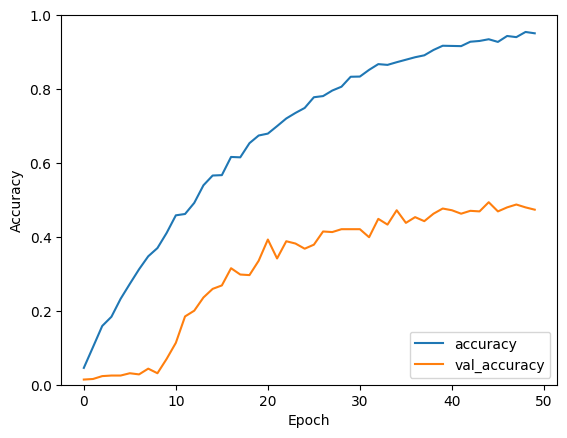

In [42]:
model_cnn = Sequential([
    tf.keras.layers.InputLayer(input_shape=(image_height, image_width, channels)),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    BatchNormalization(),

    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    BatchNormalization(),

    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    BatchNormalization(),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(num_classes, activation='softmax')
])

model_cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model_cnn.summary()
history = model_cnn.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

test_loss, test_acc = model_cnn.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

This model was able to achieve 48% accuracy on the test set, which is a small improvement over the previously used models (Random forest model had 43% accuracy).\
However, model has significant data overfitting.

#### Second, improved CNN Model

We increased dropout rates to 0.3 to provide more regularization.

Added L2 regularization (kernel_regularizer=l2(0.001)) to convolutional and dense layers to penalize large weights.

Implemented early stopping to stop training when the validation loss stops improving for 10 epochs, restoring the best weights observed during training.

Increased the number of epochs to 100, allowing early stopping to determine the best point to stop training.

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 63, 63, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 30, 30, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 87)             │        22,359 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,540,311 (24.95 MB)

 Trainable params: 6,539,351 (24.95 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 15s 213ms/step - accuracy: 0.0228 - loss: 5.5670 - val_accuracy: 0.0093 - val_loss: 5.3484
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 11s 184ms/step - accuracy: 0.0795 - loss: 4.8104 - val_accuracy: 0.0311 - val_loss: 5.6861
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 11s 184ms/step - accuracy: 0.1466 - loss: 4.3489 - val_accuracy: 0.0248 - val_loss: 6.1396
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - accuracy: 0.1576 - loss: 4.1109 - val_accuracy: 0.0280 - val_loss: 6.1197
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 12s 191ms/step - accuracy: 0.2170 - loss: 3.8716 - val_accuracy: 0.0466 - val_loss: 5.9494
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 12s 192ms/step - accuracy: 0.2482 - loss: 3.7037 - val_accuracy: 0.0419 - val_loss: 5.8230
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 12s 191ms/step - accuracy: 0.2956 - loss: 3.5363 - val_accuracy: 0.0388 - val_loss: 5.6124
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 11s 185ms/step - accuracy: 0.3086 - loss: 3.3576 - 

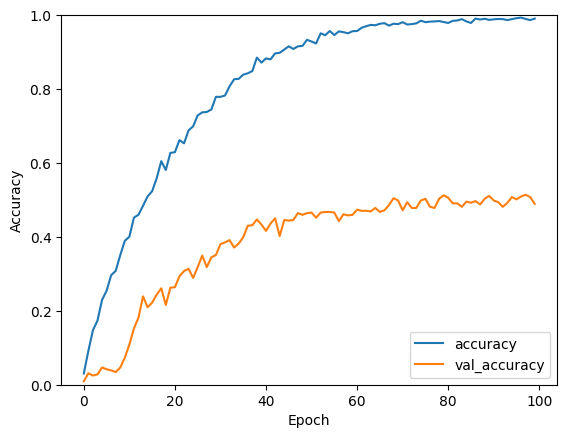

In [43]:
model_cnn_improved = Sequential([
    tf.keras.layers.InputLayer(input_shape=(image_height, image_width, channels)),
    Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    BatchNormalization(),

    Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    BatchNormalization(),

    Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    BatchNormalization(),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    BatchNormalization(),
    Dense(num_classes, activation='softmax')
])

model_cnn_improved.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model_cnn_improved.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model_cnn_improved.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

test_loss, test_acc = model_cnn_improved.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

This improved model achieved 54% accuracy on the test dataset, which is 6 p.p. higher than the first CNN model. Overfitting is still present.

Predictions - improved CNN model

In [44]:
num_images_to_show = 25

def plot_images(images, labels, predictions, indices, title):
    fig, axes = plt.subplots(5, 5, figsize=(18, 18))
    for i, ax in enumerate(axes.flat):
        if i < len(indices):
            idx = indices[i]
            ax.imshow(images[idx].reshape(128, 128, 3))
            true_label = labels[idx]
            predicted_label = predictions[idx]
            color = 'red' if true_label != predicted_label else 'black'
            ax.set_title(f"True: {true_label}\nPred: {predicted_label}", color=color)
            ax.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


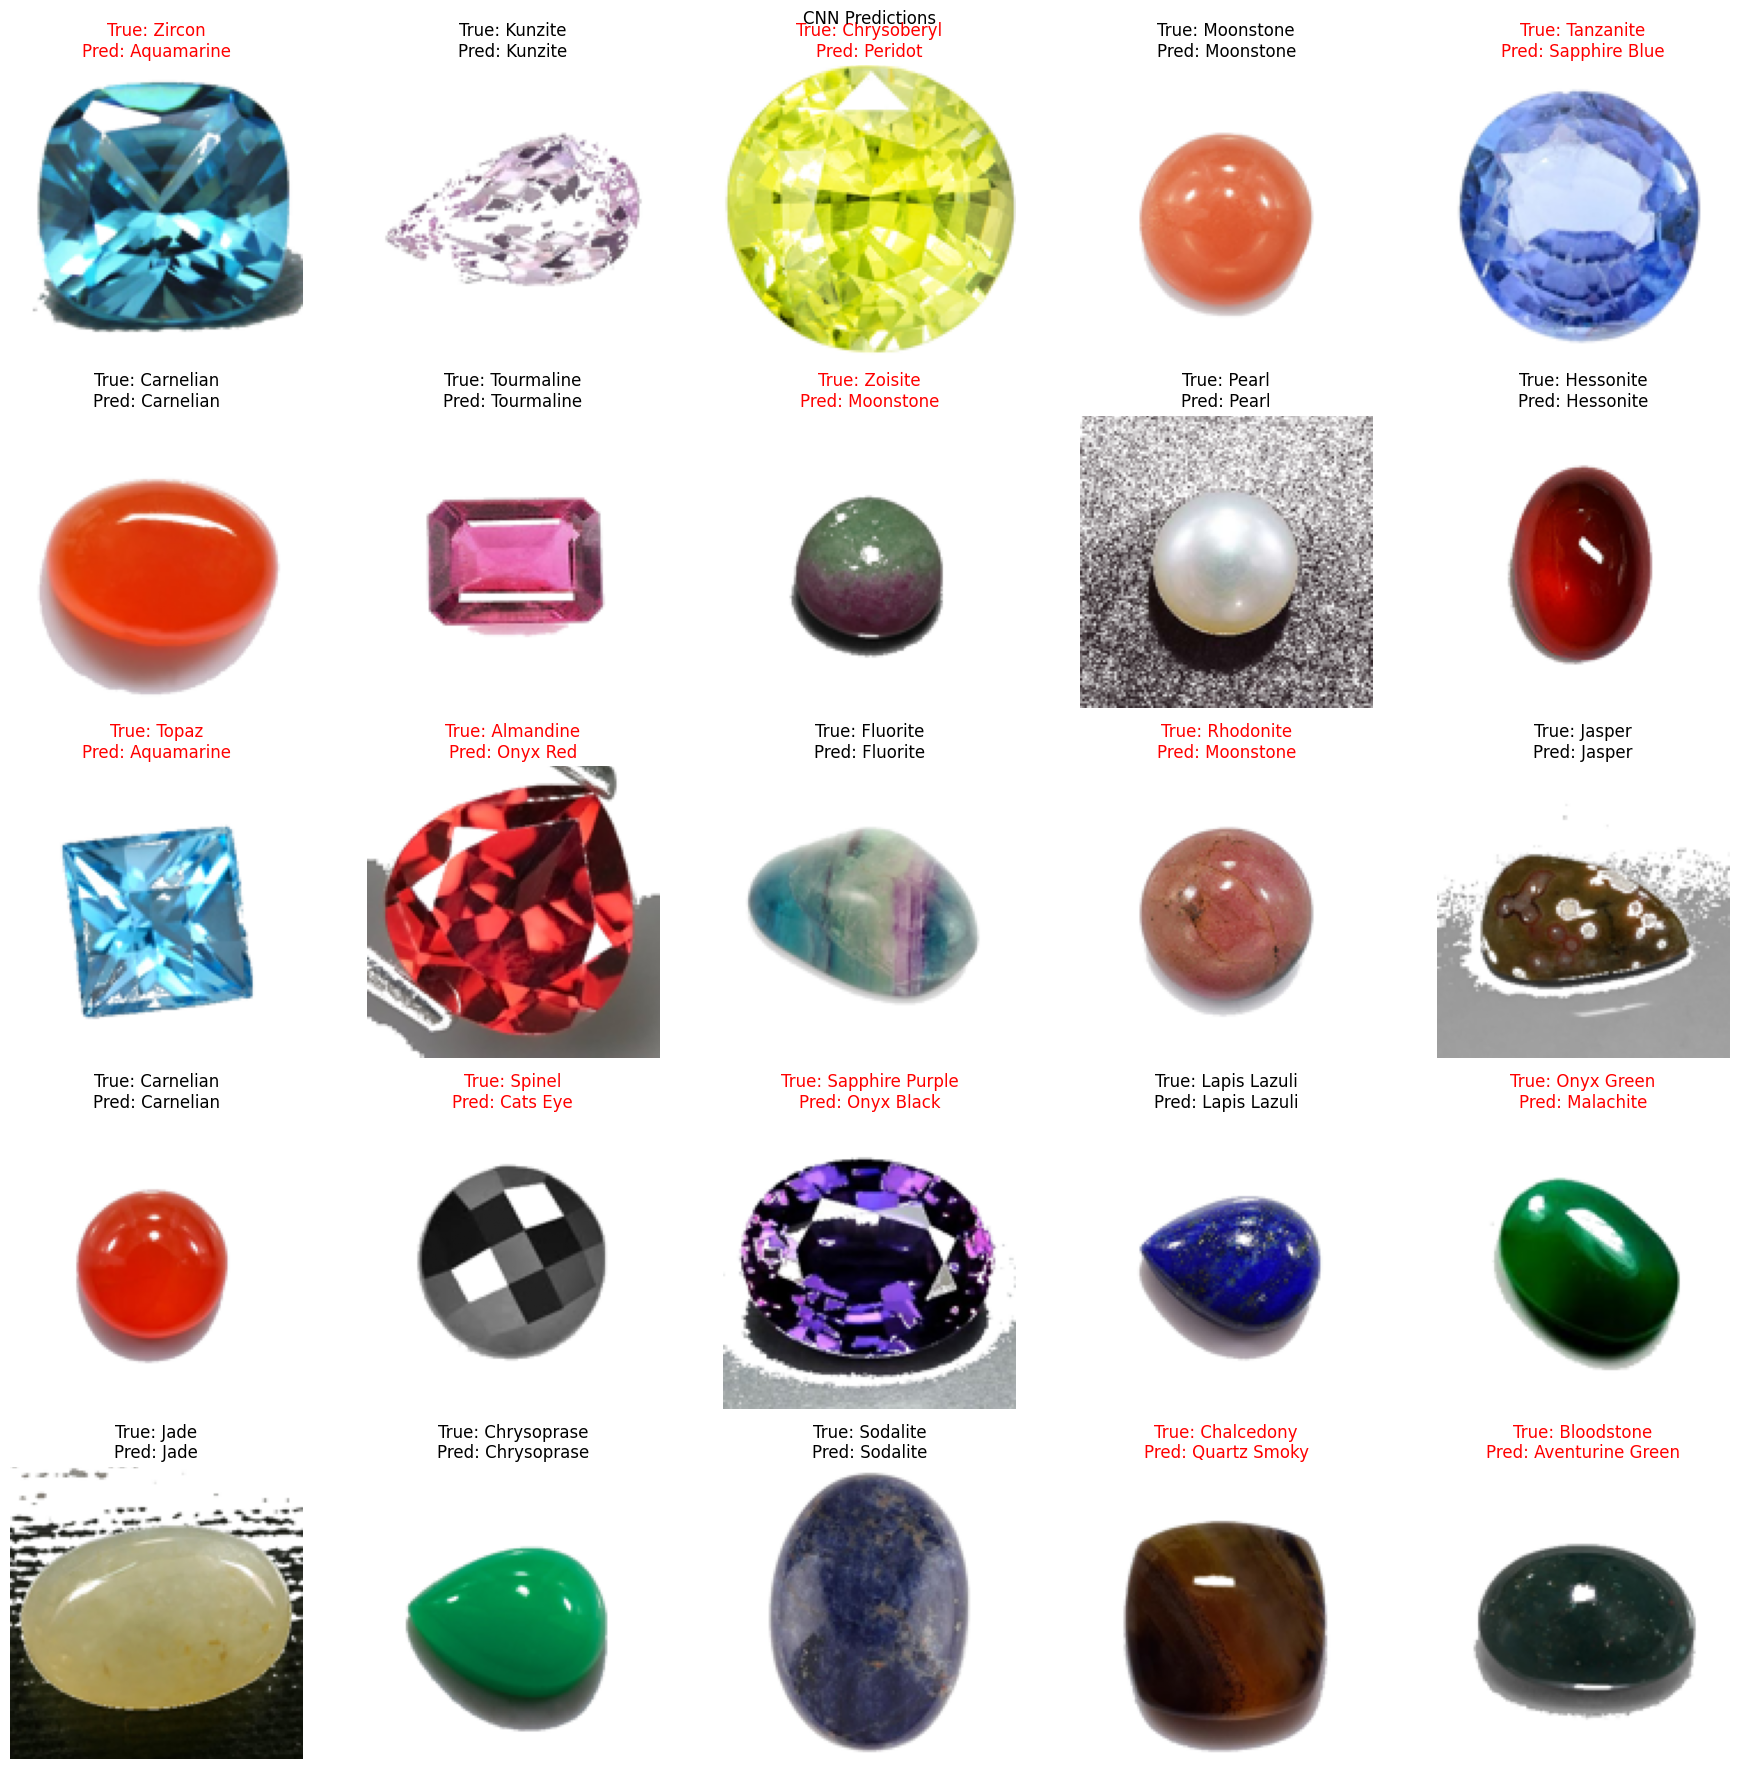

In [45]:
cnn_probabilities = model_cnn_improved.predict(X_test)
cnn_predictions = np.argmax(cnn_probabilities, axis=1)
cnn_predictions = label_encoder.inverse_transform(cnn_predictions)
cnn_labels = np.argmax(y_test, axis=1)
cnn_labels = label_encoder.inverse_transform(cnn_labels)

cnn_misclas_idxs = np.argwhere(cnn_predictions != cnn_labels).flatten()
cnn_correct_idxs = np.argwhere(cnn_predictions == cnn_labels).flatten()

cnn_num_misclassified_to_show = min(len(cnn_misclas_idxs), num_images_to_show // 2)
cnn_num_correct_to_show = num_images_to_show - cnn_num_misclassified_to_show

cnn_random_misclas_indices = np.random.choice(cnn_misclas_idxs, cnn_num_misclassified_to_show, replace=False)
cnn_random_correct_indices = np.random.choice(cnn_correct_idxs, cnn_num_correct_to_show, replace=False)

cnn_combined_indices = np.concatenate([cnn_random_misclas_indices, cnn_random_correct_indices])
np.random.shuffle(cnn_combined_indices)

plot_images(X_test, cnn_labels, cnn_predictions, cnn_combined_indices, title="CNN Predictions")

CNN models performed better then previous models.\
However, there is a signifficant overfitting. Moreover, computation time for CNN models are significantly worse then previous models - time increased from less then a minute to 10 minutes for first model (50 epochs) and to 20 minutes for second model (100 epochs).\
We believe that the increased accuracy does not translate into a significant increase in processing time.

### Model development - based on image histograms

We will try using histograms to train models because we expect this approach to keep/increase model's ability to recognize shapes, edges and structures, and to improve generalization, which might help the model to handle new, unseen data. Also we expect computation time to decrease when compared to CNNs.

We have chosen Histogram of Oriented Gradients (HOG) and color histograms. HOG focuses on the structure or the shape of an object by capturing the distribution of intensity gradients or edge directions. We assume that models will perform better when combining trianing based on color histograms and hog features.

#### Data preparation and split

In [36]:
images = df.drop(columns=['label']).values
labels = df['label'].values

def extract_hog_features(image):
    gray_image = color.rgb2gray(image)
    fd = hog(gray_image, orientations=8, pixels_per_cell=(16, 16),
             cells_per_block=(1, 1), visualize=False)
    return fd

def extract_color_histogram(image, bins=(8, 8, 8)):
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

combined_features = []
images_list = []

for image_vector in images:
    image = image_vector.reshape(128, 128, 3)
    images_list.append(image)
    hog_feature = extract_hog_features(image)
    color_hist_feature = extract_color_histogram(image)
    combined_feature = np.hstack((hog_feature, color_hist_feature))
    combined_features.append(combined_feature)

combined_features = np.array(combined_features)
scaler = StandardScaler()
combined_features_normalized = scaler.fit_transform(combined_features)

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
categorical_labels = to_categorical(encoded_labels)

X_train_val, X_test, y_train_val, y_test, images_train_val, images_test = train_test_split(
    combined_features_normalized, encoded_labels, images_list, test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val, images_train, images_val = train_test_split(
    X_train_val, y_train_val, images_train_val, test_size=0.25, random_state=42
)

categorical_labels_train_val = to_categorical(y_train_val)
categorical_labels_test = to_categorical(y_test)

X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(
    X_train_val, categorical_labels_train_val, test_size=0.25, random_state=42
)

#### Support Vector Machine

In [37]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train, y_train)

y_val_pred = svm_classifier.predict(X_val)
y_test_pred = svm_classifier.predict(X_test)

print("Validation Set Performance:")
print(classification_report(y_val, y_val_pred))
print("Test Set Performance:")
print(classification_report(y_test, y_test_pred))

print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

Validation Set Performance:
              precision    recall  f1-score   support

           0       0.56      0.62      0.59         8
           1       0.17      0.40      0.24         5
           2       0.60      0.38      0.46         8
           3       0.33      0.29      0.31         7
           4       0.50      0.38      0.43         8
           5       0.83      0.50      0.62        10
           6       0.33      0.43      0.38         7
           7       0.25      0.25      0.25         4
           8       0.42      0.45      0.43        11
           9       0.62      0.80      0.70        10
          10       0.88      0.88      0.88         8
          11       0.43      0.50      0.46         6
          12       0.13      0.29      0.18         7
          13       0.82      0.90      0.86        10
          14       0.36      0.80      0.50         5
          15       0.80      0.80      0.80         5
          16       0.75      0.43      0.55         7

c:\Users\IZO21\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\IZO21\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\IZO21\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

We can see that test accuracy on SVM model trained on HOG and color histograms scored value of 0.545 when on improved CNN we got 0.539.\
Also, computation time for data preparation and training SVM model took less then half a minute, compared to 20 minutes of improved CNN.\
This is so far the most promising model, as it shares low computation time from our first machine learning models and accuracy of CNN models.

#### Neural Netwrok

We want also to try how neural network model will perform while being trained on histograms.

Epoch 1/100


c:\Users\IZO21\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0116 - loss: 5.0606 - val_accuracy: 0.0311 - val_loss: 4.4002
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0250 - loss: 4.4659 - val_accuracy: 0.0823 - val_loss: 4.3044
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0387 - loss: 4.4157 - val_accuracy: 0.1227 - val_loss: 4.1504
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0640 - loss: 4.2400 - val_accuracy: 0.1739 - val_loss: 3.9864
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0915 - loss: 4.0216 - val_accuracy: 0.2267 - val_loss: 3.8302
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1037 - loss: 3.9522 - val_accuracy: 0.2764 - val_loss: 3.5807
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1524 - loss: 3.6708 - val_accuracy: 0.3261 - val_loss: 3.2476
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1923 - loss: 3.4849 - val_accuracy: 0.3292 - val_loss: 3.0

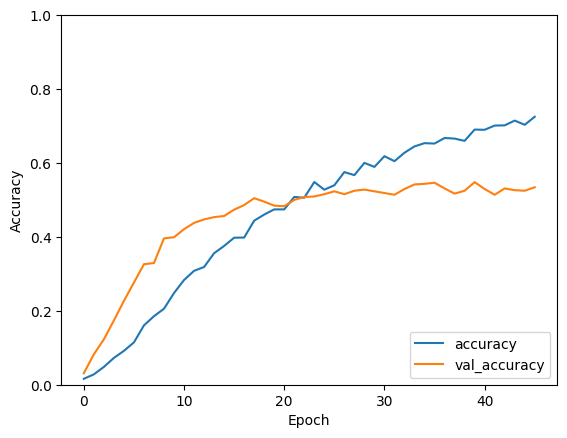

In [38]:
model = Sequential()
model.add(Dense(512, input_shape=(combined_features_normalized.shape[1],), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(categorical_labels.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train_nn, y_train_nn, validation_data=(X_val_nn, y_val_nn), epochs=100, batch_size=32, callbacks=[early_stopping])

y_test_categorical = to_categorical(y_test)

test_loss, test_accuracy = model.evaluate(X_test, y_test_categorical)
print(f"Test Accuracy: {test_accuracy}")

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

Model performed slightly worse then improved CNN or SVM, but significantly reduced overfitting and computation time when compared to CNN models.

#### Predictions - SVM

So that, we believe that the best model is SVM trained on histograms. We will plot predictions made on test set to see which gemstones were predicted right or missclassified.

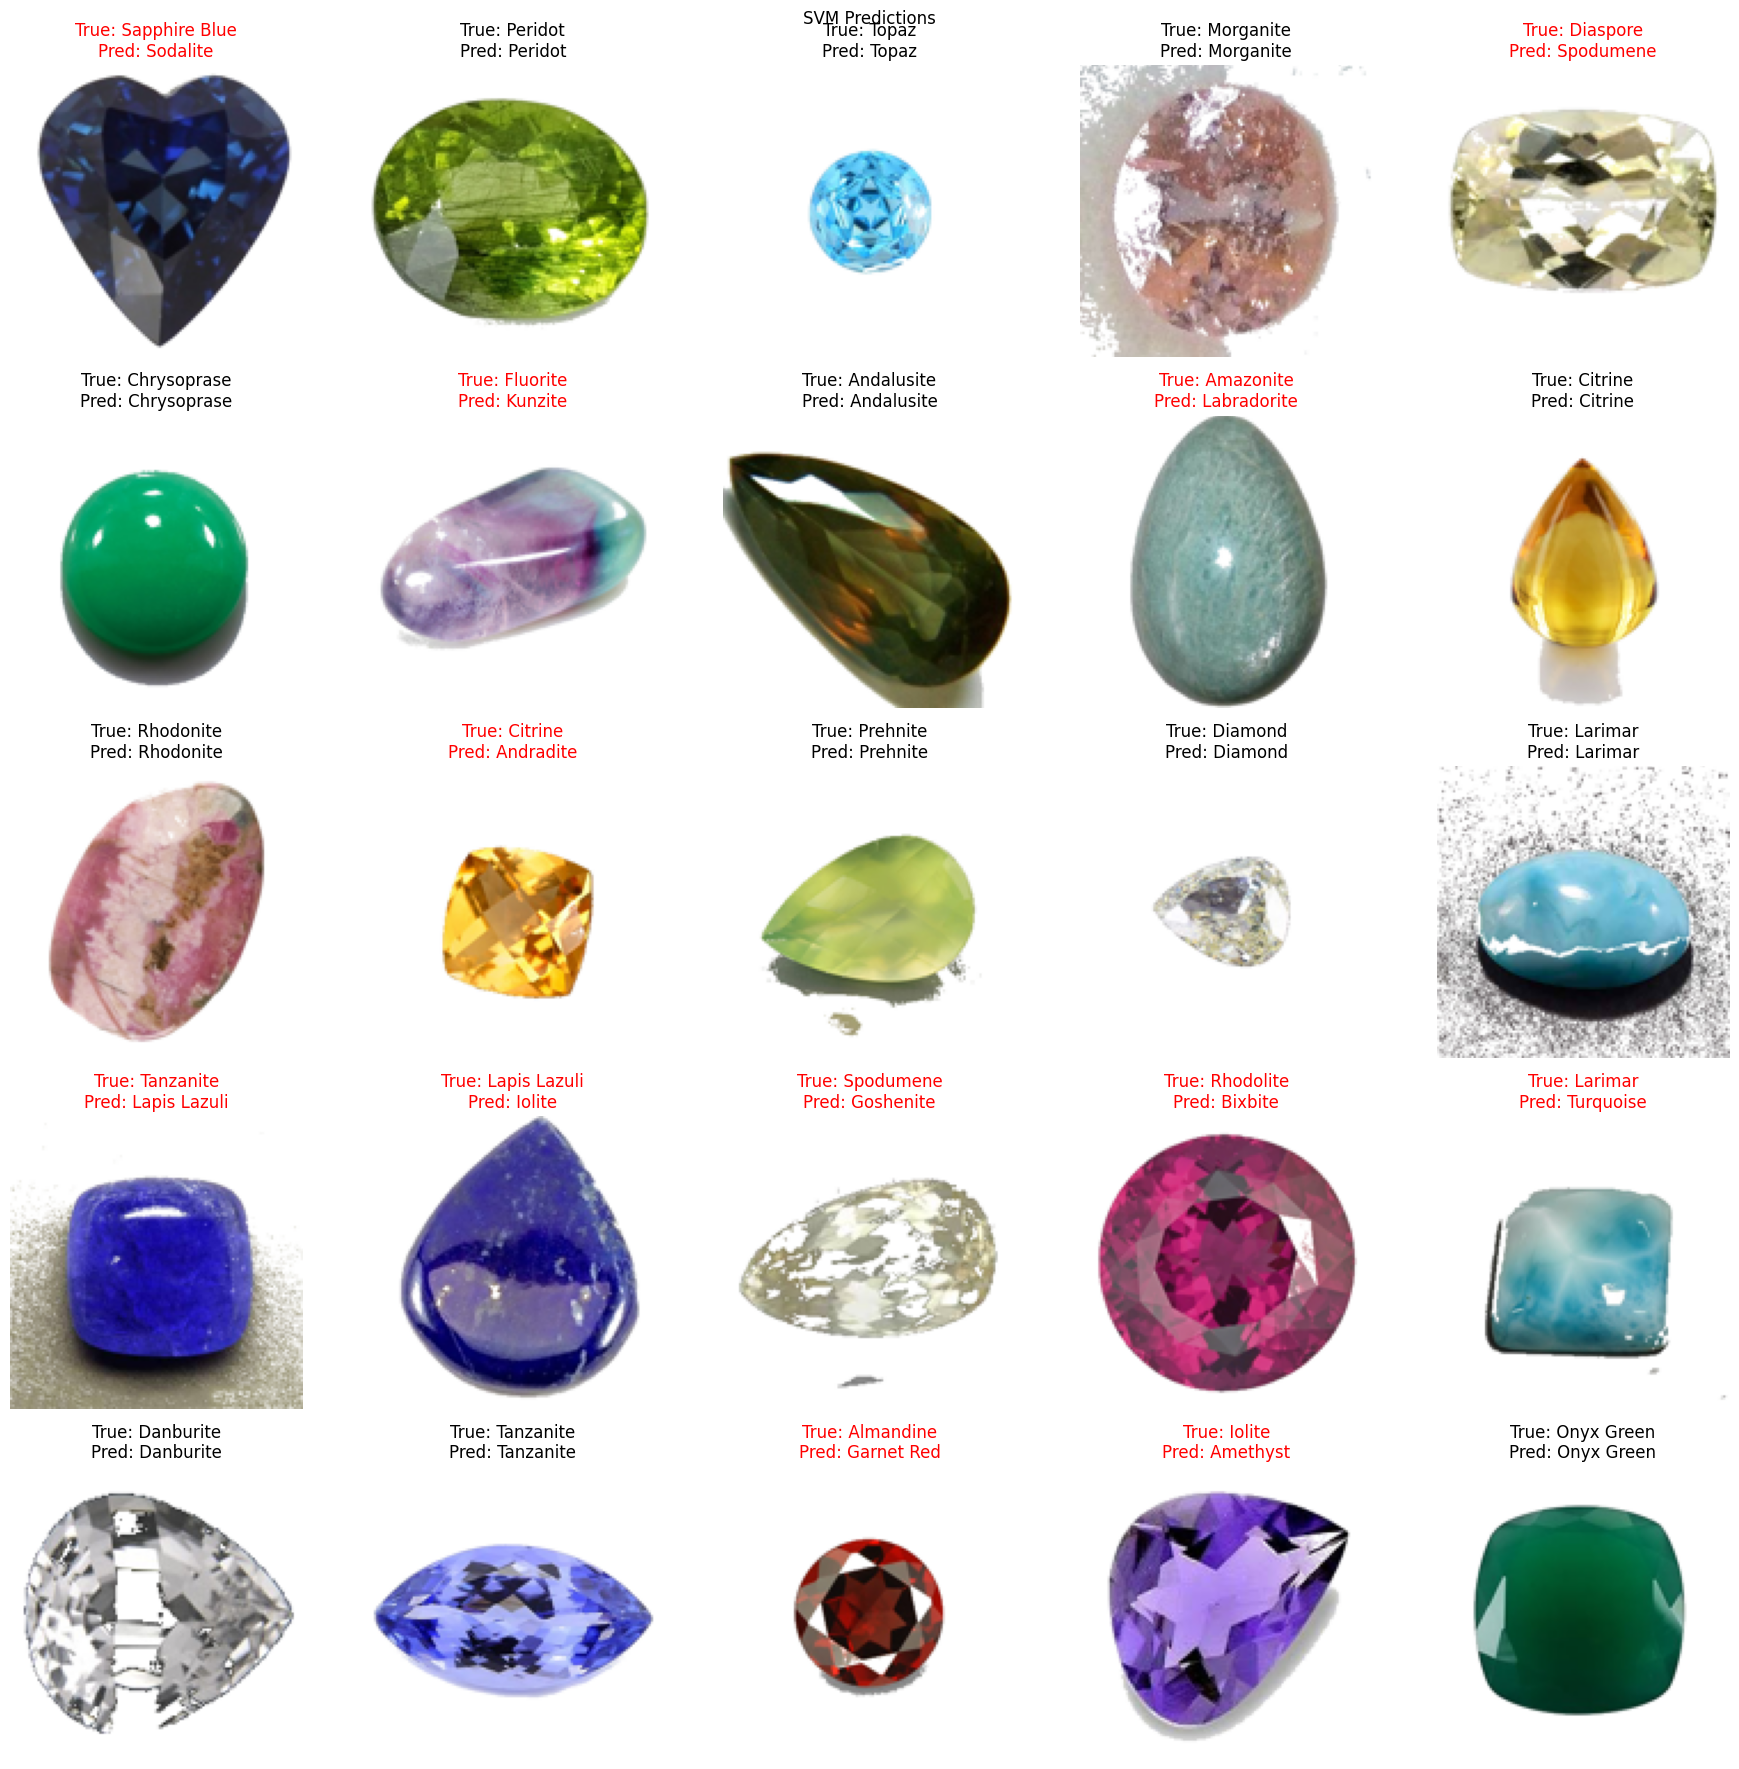

In [39]:
num_images_to_show = 25

def plot_images(images, labels, predictions, indices, title):
    fig, axes = plt.subplots(5, 5, figsize=(18, 18))
    for i, ax in enumerate(axes.flat):
        if i < len(indices):
            idx = indices[i]
            ax.imshow(images[idx].astype(np.uint8))
            true_label = labels[idx]
            predicted_label = predictions[idx]
            color = 'red' if true_label != predicted_label else 'black'
            ax.set_title(f"True: {true_label}\nPred: {predicted_label}", color=color)
            ax.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

svm_predictions = label_encoder.inverse_transform(y_test_pred)
svm_labels = label_encoder.inverse_transform(y_test)

svm_misclas_idxs = np.argwhere(svm_predictions != svm_labels).flatten()
svm_correct_idxs = np.argwhere(svm_predictions == svm_labels).flatten()

svm_num_misclassified_to_show = min(len(svm_misclas_idxs), num_images_to_show // 2)
svm_num_correct_to_show = num_images_to_show - svm_num_misclassified_to_show

svm_random_misclas_indices = np.random.choice(svm_misclas_idxs, svm_num_misclassified_to_show, replace=False)
svm_random_correct_indices = np.random.choice(svm_correct_idxs, svm_num_correct_to_show, replace=False)

svm_combined_indices = np.concatenate([svm_random_misclas_indices, svm_random_correct_indices])
np.random.shuffle(svm_combined_indices)

plot_images(images_test, svm_labels, svm_predictions, svm_combined_indices, title="SVM Predictions")


### Conclusion

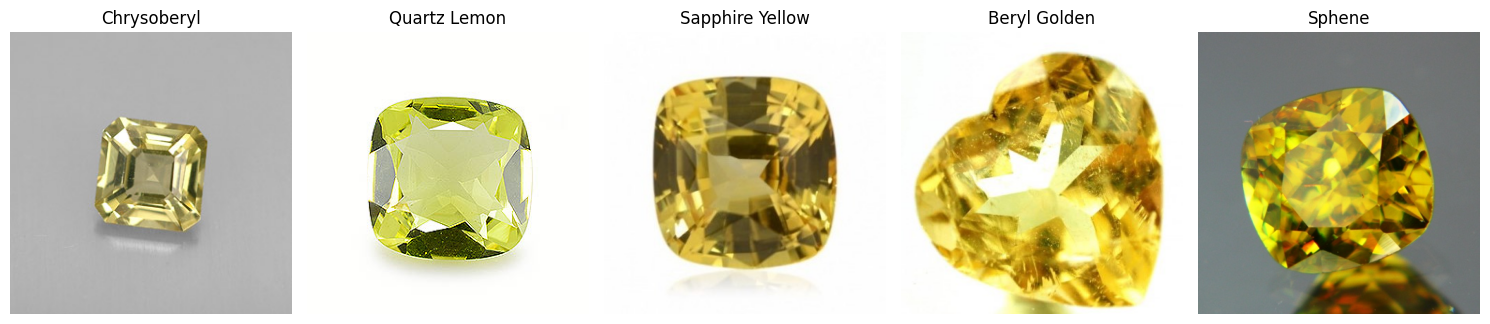

In [40]:
def show_specific_images(dataset_folder, image_relative_paths, extensions=['.jpg']):
    num_images = len(image_relative_paths)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    
    for i, relative_path in enumerate(image_relative_paths):
        image_found = False
        for ext in extensions:
            image_path = os.path.normpath(os.path.join(dataset_folder, relative_path + ext))
            if os.path.exists(image_path):
                image_found = True
                break
        
        if not image_found:
            print(f"File not found for {relative_path} with extensions {extensions}")
            continue
        
        img = mpimg.imread(image_path)
        ax = axes[i]
        ax.imshow(img)
        
        category = os.path.basename(os.path.dirname(image_path))
        image_name = os.path.basename(image_path)
        ax.set_title(f"{category}")
        
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

image_relative_paths = [
    "test/Chrysoberyl/chrysoberyl_18",
    "test/Quartz Lemon/quartz lemon_18",
    "test/Sapphire Yellow/sapphire yellow_3",
    "test/Beryl Golden/beryl golden_6",
    "test/Sphene/sphene_3"
]

show_specific_images(dataset_folder, image_relative_paths)

In this project, we tried to solve an important, complex and interesting problem using machine learning tools - recognizing and classifying gemstones. We found a dataset with a wide variety of gemstones - with almost 90 categories and numerous photos in each category. We assumed that working with gemstones would be a challenge due to the number of categories and especially because of how similar gemstones from different categories are to each other. For example, the photo above shows gemstones from different categories—Chrysoberyl, Quartz Lemon, Sapphire Yellow, Beryl Golden, and Sphene—that look identical.

We prepared photos for the models and carried out iterative experiments on various models, improving them or changing the data on which the models learned.

Taking into account the number of categories and the similarity of gemstones, the obtained result of almost 55% accuracy for both the SVM and CNN models and about 45% for Random Forest Classifier, we believe that these results are satisfactory.